# 4. Are Wildfires in Sardinia getting worse?

My gut feeling as a millenial is that climate change is rapidly increasing its pacing, entailing a manifold of problematic environmental effects. Thus, I would assume that as heat waves and extreme climatic conditions are occuring more frequently, so are wildfires. However, this is a great basic and also biased hypothesis that we may test using actual data. Of course, we first will need to load that data.

In [176]:
import pickle

with open("../data/all_data_processed.pkl", "rb") as datafile:
    data = pickle.load(datafile)
    
# some settings to center plots
from IPython.core.display import HTML
HTML("""<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>""")

## 4.1 The hypothesis

So the hypothesis that we are trying to prove is the following:

**`H1: Fires have been increasing in size and frequency over the past decade.`**

If that were not the case, meaning the inverse would be true, leads us to our null hypothesis:

**`H0: Fires have not changed in size or frequency or even decreased.`**

## 4.2 The analysis

The first thing that comes to mind is to actually have a look at the amount of burned area and also the number of fires over the past years. Let's also throw a least-squares fit of a 1th degree polynomial into the plot to better capture any obvious trends in the data.

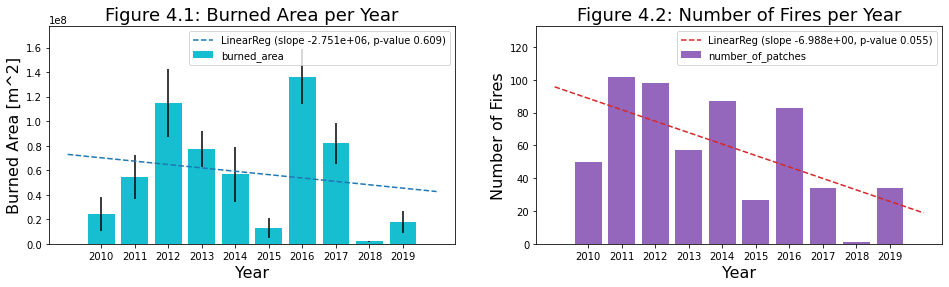

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

n_years = len(np.unique(data["year"]))

# binning of data into years
yearly_burned_area = np.asarray([np.sum(data["burned_area"][i*12:(i+1)*12, :, :]) for i in range(n_years)])
yearly_burned_area_std = np.asarray([np.sum(data["standard_error"][i*12:(i+1)*12, :, :]) for i in range(n_years)])
yearly_number_of_fires = np.asarray([np.sum(data["number_of_patches"][i*12:(i+1)*12, :, :]) for i in range(n_years)])

plt.figure(figsize=(16,4))

# fit & plot burned area
plt.subplot(121)
x  = data["year"][0]+np.arange(n_years)
x_ = data["year"][0]-1+np.arange(n_years+2)
slope_ba, intercept_ba, r_value_ba, p_value_ba, std_err_ba = stats.linregress(x,yearly_burned_area)
plt.bar(x, yearly_burned_area, color="tab:cyan", label="burned_area", yerr=yearly_burned_area_std)
plt.plot(x_, slope_ba*x_+intercept_ba, "--", color="tab:blue",\
         label=f"LinearReg (slope {slope_ba:0.03e}, p-value {p_value_ba:0.03f})")
plt.xlabel("Year", fontsize=16)
plt.xticks(x)
plt.ylabel("Burned Area [m^2]", fontsize=16)
plt.ylim([0,np.max(yearly_burned_area)*1.3])
plt.title("Figure 4.1: Burned Area per Year", fontsize=18)
plt.legend()

# fit & plot number of fires
plt.subplot(122)
n_fires_poly = Polynomial(polyfit(x, yearly_number_of_fires, deg=1))
slope_nf, intercept_nf, r_value_nf, p_value_nf, std_err_nf = stats.linregress(x,yearly_number_of_fires)
plt.bar(x, yearly_number_of_fires, color="tab:purple", label="number_of_patches")
plt.plot(x_, slope_nf*x_+intercept_nf, "--", color="tab:red", label=f"LinearReg (slope {slope_nf:0.03e}, p-value {p_value_nf:0.03f})")
plt.ylim([0,np.max(yearly_number_of_fires)*1.3])
plt.xlabel("Year", fontsize=16)
plt.xticks(x)
plt.ylabel("Number of Fires", fontsize=16)
plt.legend()
_ = plt.title("Figure 4.2: Number of Fires per Year", fontsize=18)

Well, at least for the entire island it seems that wildfires have been decreasing in the time frame between 2010 to 2019. **Figure 4.1** and **Figure 4.2** show that the overall trend is negative. However, we do know that this timeframe is very narrow and may not be suitable to answer this kind of question. The `p-value=0.609` shows the fit of the `burned_area` data is not really anywhere near being statistically significant. The same does not apply for number of fires per year. Here the linear regression does come much closer to a believable result. After all, we already know that in 2009 a fire of over `3e8 m^2` and in 2021 a `2e8 m^2` fire have occurred. This does not really let us rule out neither the null hypothesis, nor the alternative one.

If fires were actually decreasing, could this also be related to the amount of fuel on the island? After a big wildfire event there might not be enough vegetation left to provide fuel for another big event in the coming year. Let's have a look at the total burnable area on the island over time, which is conveniently provided by the Modis dataset as well.

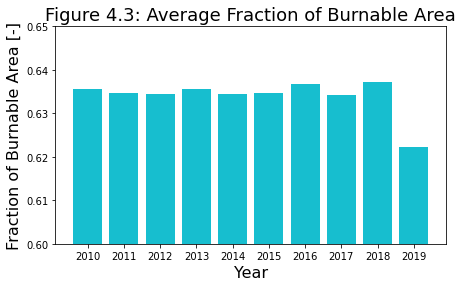

In [110]:
n_years = len(np.unique(data["year"]))
yearly_burnable_fraction = np.asarray([np.sum(data["fraction_of_burnable_area"][i*12:(i+1)*12, :, :])\
                                      /np.sum(data["fraction_of_observed_area"][i*12:(i+1)*12, :, :])\
                                       for i in range(n_years)])

plt.figure(figsize=(7,4))

x  = data["year"][0]+np.arange(n_years)
plt.xticks(x)
plt.bar(x, yearly_burnable_fraction, color="tab:cyan", label="fraction_of_burned_area")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Fraction of Burnable Area [-]", fontsize=16)
plt.ylim([0.60,0.65])
_ = plt.title("Figure 4.3: Average Fraction of Burnable Area", fontsize=18)

**Figure 4.3** shows the fraction of burnable area in the grid cells which were actually observable, which means we are excluding water for example. However, the variability in the amount of possibly burnable area is very low and does not indicate influence on the decreasing wildfires within the selected timeframe.

It looks like we currently cannot gather enough evidence to support our hypothesis. From the current perspective it looks like the inverse is true, wildfires are actually decreasing in the area. Yet, my intuition says that that is mainly due to our narrow field of view. So, let's have a look outside the box, as we are able to acquire almost twice the amount of wildfire data from the Modis dataset if we drop our "only 10-years" constraint. Our data compiler makes it easy to get much more data.

In [ ]:
import yaml   
import sys
sys.path.append("../lib")
from ModisCompiler import ModisCompiler

with open("../auth.yaml","r") as authfile:
    data = yaml.safe_load(authfile)
    cds_key = data['cds-api-token']['uid']+":"+data['cds-api-token']['key']
    
compiler = ModisCompiler(cds_key)
compiler.compile(
    "../data/modis_data_extended.pkl",
    vars = ["burned_area",       
            "number_of_patches", 
            "standard_error"],   
    timeframe = (2001, 2019),    # we break out the boxed challenge and take all the data there is.
    region = "../data/sardinia.shp"
)

Let's see if we are able to disprove `H0`, now that we have got almost 20 years of wildfire observations of Sardinia. We will also include our latest data point for 2021 into the polynomial fit, which is around `200 million m^2`. I could not find any good data on the year `2020`, thus we will leave it empty with maximum uncertainty.

In [114]:
import pickle

with open("../data/modis_data_extended.pkl", "rb") as datafile:
    data = pickle.load(datafile)

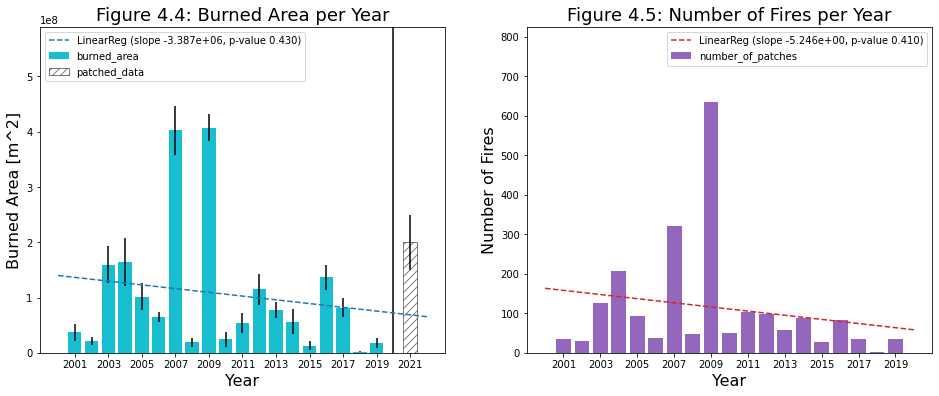

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

burned_area_in_2021 = 2e8

# binning the data into years
n_years = len(np.unique(data["year"]))
yearly_burned_area = [np.sum(data["burned_area"][i*12:(i+1)*12, :, :]) for i in range(n_years)]
yearly_burned_area_std = [np.sum(data["standard_error"][i*12:(i+1)*12, :, :]) for i in range(n_years)]
yearly_number_of_fires = [np.sum(data["number_of_patches"][i*12:(i+1)*12, :, :]) for i in range(n_years)]
                                    
# manually patching the burned_area data points
yearly_burned_area.append(0) # we have no information about 2020
yearly_burned_area.append(burned_area_in_2021)
yearly_burned_area_std.append(1e10) # so the uncertainty about this information is infinite
yearly_burned_area_std.append(5e7)  # assumption


plt.figure(figsize=(16,6))

# fit & plot burned_area
plt.subplot(121)

x  = data["year"][0]+np.arange(n_years+2)
x_ = data["year"][0]-1+np.arange(n_years+4)
x_ticks = data["year"][0]+np.arange(n_years+2, step=2)
slope_ba, intercept_ba, r_value_ba, p_value_ba, std_err_ba = stats.linregress(x,yearly_burned_area)
plt.bar(x[:-1], yearly_burned_area[:-1], color="tab:cyan", label="burned_area", yerr=yearly_burned_area_std[:-1])
plt.bar(x[-1], yearly_burned_area[-1], color="tab:cyan", alpha=0.5, 
        label="patched_data", yerr=yearly_burned_area_std[-1], fill=False, hatch='///')
plt.plot(x_, slope_ba*x_+intercept_ba, "--", color="tab:blue",\
         label=f"LinearReg (slope {slope_ba:0.03e}, p-value {p_value_ba:0.03f})")
plt.xticks(x_ticks)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Burned Area [m^2]", fontsize=16)
plt.ylim([0,np.max(yearly_burned_area)*1.45])
plt.title("Figure 4.4: Burned Area per Year", fontsize=18)
plt.legend(loc="upper left")

# fit & plot number_of_fires
plt.subplot(122)
x  = data["year"][0]+np.arange(n_years)
x_ = data["year"][0]-1+np.arange(n_years+2)
x_ticks = data["year"][0]+np.arange(n_years, step=2)
slope_nf, intercept_nf, r_value_nf, p_value_nf, std_err_nf = stats.linregress(x,yearly_number_of_fires)
plt.bar(x, yearly_number_of_fires, color="tab:purple", label="number_of_patches")
plt.plot(x_, slope_nf*x_+intercept_nf, "--", color="tab:red", label=f"LinearReg (slope {slope_nf:0.03e}, p-value {p_value_nf:0.03f})")
plt.xticks(x_ticks)
plt.ylim([0,np.max(yearly_number_of_fires)*1.3])
plt.xlabel("Year", fontsize=16)
plt.ylabel("Number of Fires", fontsize=16)
plt.legend()
_ = plt.title("Figure 4.5: Number of Fires per Year", fontsize=18)

**Figure 4.4** and **Figure 4.5** show that for a period of 20 years the amount of burned area on the island has been decreasing. This means even with more data, we are not able to confirm our hypothesis `H1`. Any conclusions drawn from this will just be speculation at this point as the linear regressions are not indicating any meaning full relation between `time` and `burned_area` with the `p-value` of both fits substantially above any nominal threshold. 

Wildfires are a very complex phenomena, where not only the environment and the climate are involved, but also how well the local authorities are prepared and how they react. Thus, it might very well be that the Sardinian's are effectively getting better at locating and extinguishing fires on their island.